## **Part 2 - Product Category Clustering**
-  Objective: Simplify the dataset by clustering product categories into 4-6 meta-categories.

#### Imports

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from rapidfuzz import process
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


#### Load the Dataset

In [54]:
# Define dataset path
dataset_path = r'.\Dataset\cleaned_reviews.csv'

data = pd.read_csv(dataset_path, low_memory=False)

# Reset index 
data.reset_index(drop=True, inplace=True)

# Print dataset shape and column names for verification
print('Rows/Columns: ', data.shape)
print('Column Names: ', data.columns)

# Display first 5 rows
data.head(5)

Rows/Columns:  (59046, 6)
Column Names:  Index(['name', 'brand', 'categories', 'reviews.doRecommend', 'reviews.rating',
       'reviews'],
      dtype='object')


,name,brand,categories,reviews.doRecommend,reviews.rating,reviews
0,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"Featured Brands,E-Readers & Accessories,EBook ...",True,5.0,Great device for reading. Definately pricey.. ...
1,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"Featured Brands,E-Readers & Accessories,EBook ...",True,5.0,"Excellent Kindle. The best Kindle ever, for me..."
2,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"Featured Brands,E-Readers & Accessories,EBook ...",True,4.0,Love it. I absolutely love this reader. The bi...
3,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"Featured Brands,E-Readers & Accessories,EBook ...",True,5.0,Good kindle. I always use it when i read ebook...
4,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,"EBook Readers,Tablets,Electronics,Amazon Eread...",True,4.0,"So much to love, but slippery. Love bigger scr..."


#### Review the categories.
We need to find the unique categories and most common.

In [55]:
# Checking unique categories
unique_categories = data["categories"].unique()  
num_unique_categories = len(unique_categories)  

# Counting occurrences of each category
category_counts = data["categories"].value_counts()  

# Show the most common categories
top_categories = category_counts.head(20)  
# Print results
print(f"Total Unique Categories: {num_unique_categories}")
print("Most Common Categories:")
print(top_categories)

Total Unique Categories: 97
Most Common Categories:
categories
Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

#### Cleaning & Processing the Categories.
We eliminate multiple categories in one row, similar categories and the extra spaces and inconsistencies.

In [56]:
# Extract and clean categories
data['categories'] = data['categories'].str.lower().str.strip()
all_categories = data['categories'].str.split(',').explode().dropna().unique()

# Dictionary for cleaned category mappings
category_mapping = {}
SIMILARITY_THRESHOLD = 85  # Set similarity threshold

for cat in all_categories:
    # Find best match (if any) from already processed categories
    match = process.extractOne(cat, category_mapping.keys(), score_cutoff=SIMILARITY_THRESHOLD)
    
    if match:  # Check if a match was found
        best_match, score, _ = match  # Extract values
        category_mapping[cat] = category_mapping[best_match]
    else:
        category_mapping[cat] = cat  # Keep as is if no close match found

# Apply cleaned category mapping
data['cleaned_categories'] = data['categories'].apply(lambda x: ','.join([category_mapping[c] for c in x.split(',') if c in category_mapping]))

# Count occurrences of cleaned categories
cleaned_category_counts = pd.Series(category_mapping.values()).value_counts().reset_index()
cleaned_category_counts.columns = ['Category', 'Count']

# Display the results
print(cleaned_category_counts)

               Category  Count
0      book accessories     50
1                    tv     28
2    tvs & home theater     27
3               tablets     26
4    video & home audio     25
..                  ...    ...
66             consoles      1
67             14701001      1
68   coffee pod holders      1
69  hard-sided carriers      1
70         ways to shop      1

[71 rows x 2 columns]


Visualizing the Cleaned Categories


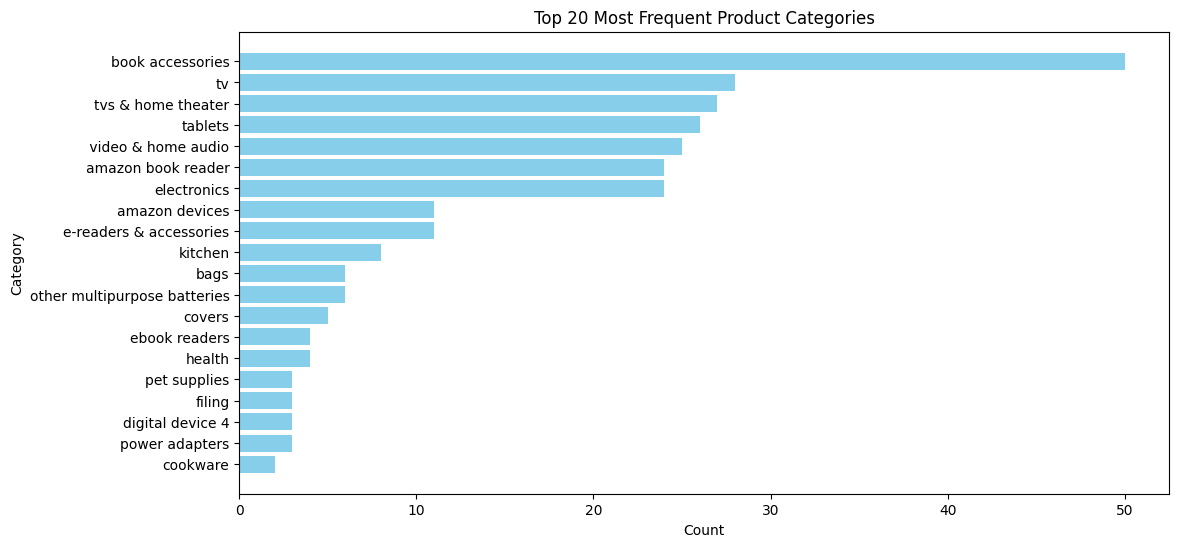

In [57]:
# Select the top 20 categories for visualization
top_20_categories = cleaned_category_counts.head(20)

# Plot bar chart
plt.figure(figsize=(12,6))
plt.barh(top_20_categories["Category"], top_20_categories["Count"], color='skyblue')
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Top 20 Most Frequent Product Categories")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()


#### Choosing the Model

Since we are clustering textual data (product categories), we should use a pre-trained model that understands language and semantic relationships. So for this ocassion I have choosed  **BERT-Based Sentence Embeddings** (sentence-transformers/all-MiniLM-L6-v2) that apply K-Means or Agglomerative Clustering for grouping.

In [58]:
# Load BERT-Based Sentence Embedding Model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Get unique cleaned product categories
categories = cleaned_category_counts["Category"].tolist()

# Convert categories into numerical embeddings using BERT
category_embeddings = model.encode(categories, convert_to_numpy=True)


Determine the Optimal Number of Clusters.
We use:
-  Elbow Method: Uses the inertia (sum of squared distances) to find the best number of clusters
- Silhouette Score Analysis: Measures cluster cohesion and separation.

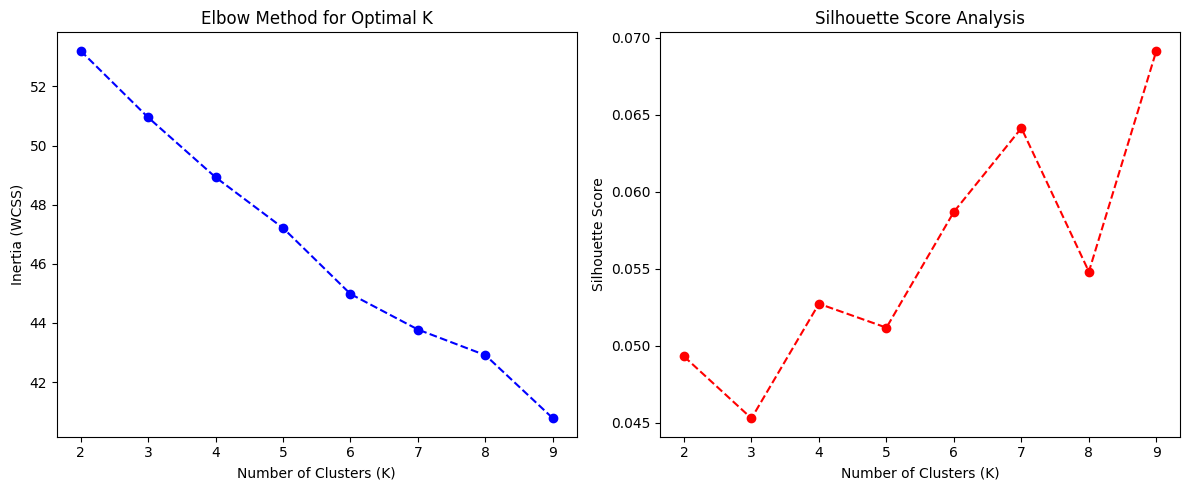

                                             Category  Count  Cluster
0                                    book accessories     50        2
1                                                  tv     28        1
2                                  tvs & home theater     27        1
3                                             tablets     26        2
4                                  video & home audio     25        1
5                                  amazon book reader     24        2
6                                         electronics     24        4
7                                      amazon devices     11        2
8                             e-readers & accessories     11        2
9                                             kitchen      8        4
10                                               bags      6        0
11                       other multipurpose batteries      6        3
12                                             covers      5        4
13                  

In [59]:
# Determine optimal number of clusters using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(2, 10)  # Test different cluster sizes

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(category_embeddings)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(category_embeddings, cluster_labels))

# Plot Elbow Curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(cluster_range, inertia, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")

# Plot Silhouette Score
plt.subplot(1,2,2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Analysis")

plt.tight_layout()
plt.show()

# Choose the best number of clusters based on elbow curve and silhouette score
optimal_k = int(input("Enter the optimal number of clusters based on analysis: "))

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cleaned_category_counts["Cluster"] = kmeans.fit_predict(category_embeddings)

# Display the clustered product categories
print(cleaned_category_counts.head(50))  # Show first 50 rows for review

##### After we decide the count of 5 clusters, we apply **K-Means Clustering**

In [60]:
optimal_clusters = 5  # Adjust based on Elbow Method

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(category_embeddings)

# Add cluster labels to the category dataframe
cleaned_category_counts['Cluster'] = cluster_labels


for cluster_num in range(optimal_clusters):
    print(f"\nCluster {cluster_num}:")
    print(cleaned_category_counts[cleaned_category_counts['Cluster'] == cluster_num]['Category'].values)




Cluster 0:
['bags' 'pet supplies' 'cookware' 'crates kennels' 'standard litter boxes'
 'dog supplies' ' tech toys' 'crate training' 'pet products' 'dogs'
 'backpacks' 'learning toys' 'robot check' 'coffee pod holders'
 'hard-sided carriers' 'ways to shop']

Cluster 1:
['tv' 'tvs & home theater' ' video & home audio' 'tvs entertainment'
 'streaming media players' 'streaming devices' 'blank audio/video media'
 'voice-enabled smart assistants' 'surveillance' 'consoles' '14701001']

Cluster 2:
['book accessories' 'tablets' 'amazon book reader' 'amazon devices'
 'e-readers & accessories' 'ebook readers' 'digital device 4'
 'amazon ereaders' 'why keep them waiting prime free two-day shipping'
 'mazon.co.uk' 'kindle e-readers' 'walmart for business' 'kindle store'
 'disc storage wallets' 'custom stores' 'holiday shop'
 'hard drive pouches' ' wi-fi  3g (unlocked...']

Cluster 3:
['other multipurpose batteries' 'power adapters' 'chargers adapters'
 'camcorder batteries']

Cluster 4:
['electron

Counting Categories in Each Cluster

In [61]:
cluster_counts = cleaned_category_counts['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Number of Categories']
print(cluster_counts)

   Cluster  Number of Categories
0        4                    22
1        2                    18
2        0                    16
3        1                    11
4        3                     4


We can see there are some categories that may fit better in other clusters so we can manually move them for better fit.

In [62]:
# Define manual category reassignments
manual_reassignments = {
    "electrical": 4,  
    "cd": 1,  
    "music": 1, 
    ' movies': 1,     
    "drives": 4,  
    "stereos": 1,  
    "speaker systems": 1, 
    "kitchen": 0,
    "aa": 3,
    'city sniffers': 4,
    "holiday shop": 0,
    "hard drive pouches": 4,
    'disc storage wallets': 4,
    'platforms': 1,
    'keyboards': 1,
    'walmart for business': 4,
    'city sniffers': 0
    
}


# Apply manual reassignments correctly
cleaned_category_counts['Cluster'] = cleaned_category_counts['Category'].map(manual_reassignments).fillna(cleaned_category_counts['Cluster'])

print(cleaned_category_counts.groupby('Cluster')['Category'].apply(list))

Cluster
0.0    [kitchen, bags, pet supplies, cookware, crates...
1.0    [tv, tvs & home theater,  video & home audio, ...
2.0    [book accessories, tablets, amazon book reader...
3.0    [other multipurpose batteries, power adapters,...
4.0    [electronics, covers, health, filing, drives, ...
Name: Category, dtype: object


This is going well so we can rename our clusters. 

In [63]:
# Define cluster name mapping
cluster_names = {
    0: "Home & Pet Supplies",
    1: "TV & Home Entertainment",
    2: "Ebook readers & Tablets",
    3: "Batteries",
    4: "General Electronics & Household"
}

# Apply cluster names
cleaned_category_counts['Cluster_Name'] = cleaned_category_counts['Cluster'].map(cluster_names)

print("\n FINAL CLUSTERED CATEGORIES:")
for cluster_name in cleaned_category_counts['Cluster_Name'].unique():
    print(f"\n {cluster_name}:")
    print(cleaned_category_counts[cleaned_category_counts['Cluster_Name'] == cluster_name]['Category'].values)


 FINAL CLUSTERED CATEGORIES:

 Ebook readers & Tablets:
['book accessories' 'tablets' 'amazon book reader' 'amazon devices'
 'e-readers & accessories' 'ebook readers' 'digital device 4'
 'amazon ereaders' 'why keep them waiting prime free two-day shipping'
 'mazon.co.uk' 'kindle e-readers' 'kindle store' 'custom stores'
 ' wi-fi  3g (unlocked...']

 TV & Home Entertainment:
['tv' 'tvs & home theater' ' video & home audio' 'tvs entertainment'
 'stereos' 'streaming media players' 'streaming devices' 'cd'
 'blank audio/video media' 'speaker systems'
 'voice-enabled smart assistants' 'surveillance' ' movies' 'platforms'
 'keyboards' 'consoles' '14701001']

 General Electronics & Household:
['electronics' 'covers' 'health' 'filing' 'drives' 'featured brands'
 'walmart for business' 'disc storage wallets' 'electrical' 'smead'
 'clearance' 'ipod' 'categories' 'frys' ' music' 'hard drive pouches']

 Home & Pet Supplies:
['kitchen' 'bags' 'pet supplies' 'cookware' 'crates kennels'
 'standard l

Visualize Category Distribution


 Showing Final Cluster Distribution...


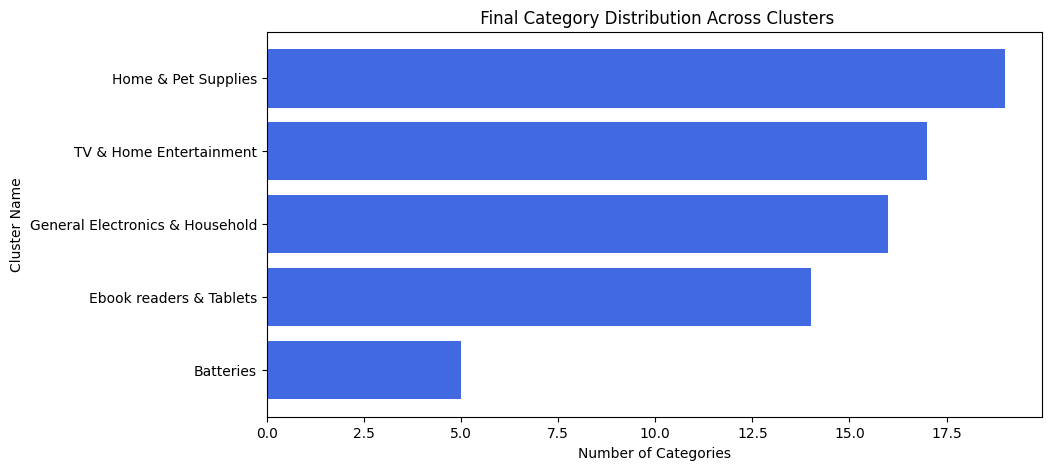

In [64]:
def plot_cluster_distribution(data):
    cluster_counts = data['Cluster_Name'].value_counts().reset_index()
    cluster_counts.columns = ['Cluster Name', 'Number of Categories']

    plt.figure(figsize=(10, 5))
    plt.barh(cluster_counts['Cluster Name'], cluster_counts['Number of Categories'], color='royalblue')
    plt.xlabel("Number of Categories")
    plt.ylabel("Cluster Name")
    plt.title(" Final Category Distribution Across Clusters")
    plt.gca().invert_yaxis()
    plt.show()

print("\n Showing Final Cluster Distribution...")
plot_cluster_distribution(cleaned_category_counts)

In [65]:
# Compute the silhouette score
sil_score = silhouette_score(category_embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0512


c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


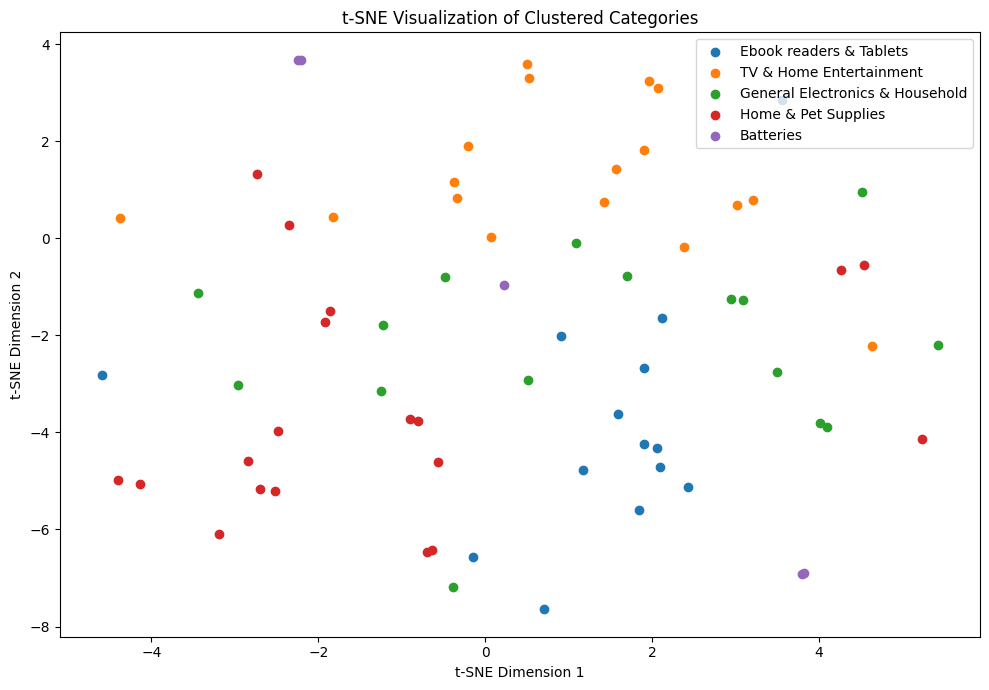

In [66]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced_embeddings = tsne.fit_transform(category_embeddings)

# Use the final cluster labels (after renaming and manual adjustment)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
final_labels = label_encoder.fit_transform(cleaned_category_counts["Cluster_Name"])

# Plot clusters
plt.figure(figsize=(10, 7))
unique_labels = cleaned_category_counts["Cluster_Name"].unique()

for label in unique_labels:
    idx = cleaned_category_counts["Cluster_Name"] == label
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=label)

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Clustered Categories")
plt.legend()
plt.tight_layout()
plt.show()

Saving the Mapping for Reuse

In [68]:
final_mapping = cleaned_category_counts[['Category', 'Cluster_Name']]
final_mapping.to_csv("category_cluster_mapping.csv", index=False)